In [2]:
using Revise
using Turing, MCMCChains
using XLSX
using DataFrames, TimeSeries
using StatsPlots
using Plots
using LinearAlgebra
using CSV
using StatsBase
include("../utils.jl")
include("../financial_bvar_temp.jl")
using .FinancialBVAR

In [3]:
df = DataFrame(XLSX.readtable("../data/usa_var_data.xlsx", "Data", infer_eltypes=true))
data_source = collapse(TimeArray(df; timestamp = :Date), Dates.quarter, last)

292×11 TimeArray{Float64, 2, Date, Matrix{Float64}} 1951-12-01 to 2024-07-01
┌────────────┬──────────┬───────────┬─────────────┬──────────┬────────┬─────────
│            │ Yeld_10Y │ Price_10Y │ Stock_Price │ Dividend │ E      │ CAPE   ⋯
├────────────┼──────────┼───────────┼─────────────┼──────────┼────────┼─────────
│ 1951-12-01 │  0.02513 │   104.098 │       24.19 │  1.41333 │   2.44 │ 12.527 ⋯
│ 1952-03-01 │  0.02505 │   104.824 │       23.74 │     1.43 │    2.4 │ 12.242 ⋯
│ 1952-06-01 │  0.02415 │   106.295 │       25.08 │     1.45 │   2.34 │ 12.669 ⋯
│ 1952-09-01 │  0.02685 │   104.468 │       24.26 │  1.43667 │   2.36 │ 12.131 ⋯
│ 1952-12-01 │  0.02547 │   106.402 │       26.18 │     1.41 │    2.4 │ 13.010 ⋯
│ 1953-03-01 │  0.02735 │   105.373 │       24.71 │  1.41333 │   2.43 │ 12.163 ⋯
│ 1953-06-01 │  0.02987 │    103.86 │       24.29 │     1.42 │   2.51 │ 11.750 ⋯
│ 1953-09-01 │  0.02636 │    107.81 │       23.97 │     1.43 │   2.55 │ 11.391 ⋯
│     ⋮      │    ⋮     │     ⋮ 

In [4]:
freq = 4
returns = percentchange(data_source[:Total_Stock, :Price_10Y], :log)
returns = merge(returns, log1p.(data_source[:T_Bill])./freq)
cpi = percentchange(data_source[:CPI], :log)
real_returns = returns .- cpi
term = data_source[:Yeld_10Y] ./freq .- data_source[:T_Bill] ./freq
dy = data_source[:Dividend_Yeld] #log.(data_source[:Dividend_Yeld])
data = merge(real_returns, dy, term, cpi)

291×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 1952-03-01 to 2024-07-01
┌────────────┬─────────────────┬───────────────┬─────────────┬───────────────┬──
│            │ Total_Stock_CPI │ Price_10Y_CPI │ T_Bill_CPI  │ Dividend_Yeld │ ⋯
├────────────┼─────────────────┼───────────────┼─────────────┼───────────────┼──
│ 1952-03-01 │      1.98335e-5 │     0.0107337 │  0.00772445 │     0.0602359 │ ⋯
│ 1952-06-01 │       0.0581411 │    0.00263202 │ -0.00708528 │      0.057815 │ ⋯
│ 1952-09-01 │      -0.0185027 │    -0.0173351 │  0.00423886 │     0.0592197 │ ⋯
│ 1952-12-01 │       0.0932838 │     0.0220972 │   0.0089235 │     0.0538579 │ ⋯
│ 1953-03-01 │      -0.0437093 │   -0.00972202 │  0.00497517 │     0.0571967 │ ⋯
│ 1953-06-01 │      -0.0100139 │    -0.0219485 │ -0.00227055 │     0.0584603 │ ⋯
│ 1953-09-01 │     -0.00574595 │     0.0298874 │ -0.00299956 │     0.0596579 │ ⋯
│ 1953-12-01 │        0.078226 │     0.0248173 │  0.00767892 │     0.0572141 │ ⋯
│     ⋮      │        ⋮        │ 

In [5]:
start = Date(1952,03,01)
end_d = Date(2019, 12, 31)
s_data = to(from(data, start),end_d)
returns_summarystats(to(from(returns, start),end_d), 4)

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
Total_Stock,0.135,0.8255,0.103,0.2711,-1.0147,-0.6026,-0.0386,0.1682,1.3459,0.7632,0.1261
Price_10Y,0.0816,0.7182,0.0566,0.1331,-0.4271,0.8114,-0.0391,-0.0181,1.8936,0.6938,0.0281
T_Bill,0.0146,0.144,0.0413,0.0561,0.0001,0.8128,0.0188,0.9537,0.9068,2.8254,0.0396


In [6]:
returns_summarystats(s_data, 1)
display("Annulaised data")
returns_summarystats(s_data, 4)

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
Total_Stock_CPI,0.0691,0.1992,0.0174,0.0609,-0.2381,-0.511,-0.0175,0.1809,0.9305,0.2515,0.0211
Price_10Y_CPI,0.0433,0.1724,0.0058,0.0267,-0.1471,0.6607,-0.0211,0.0097,1.9378,0.1337,0.0009
T_Bill_CPI,0.0074,0.0255,0.002,0.0065,-0.0208,-0.0391,-0.0024,0.3231,0.7477,0.2639,0.0026
Dividend_Yeld,0.012,0.0624,0.0309,0.0377,0.0113,0.5117,0.02,0.9676,-0.4378,2.574,0.0302
Yeld_10Y_T_Bill,0.0029,0.0099,0.0036,0.0057,-0.0077,-0.2262,0.0014,0.7937,0.2388,1.2175,0.0035
CPI,0.0087,0.0403,0.0084,0.0121,-0.0254,0.5159,0.0034,0.4768,1.8449,0.9642,0.0074


"Annulaised data"

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
Total_Stock_CPI,0.1382,0.7969,0.0695,0.2437,-0.9526,-0.511,-0.0701,0.1809,0.9305,0.503,0.0845
Price_10Y_CPI,0.0866,0.6896,0.0232,0.1067,-0.5883,0.6607,-0.0845,0.0097,1.9378,0.2674,0.0035
T_Bill_CPI,0.0149,0.1019,0.0078,0.0259,-0.0832,-0.0391,-0.0094,0.3231,0.7477,0.5277,0.0105
Dividend_Yeld,0.024,0.2495,0.1237,0.1507,0.045,0.5117,0.0802,0.9676,-0.4378,5.148,0.1207
Yeld_10Y_T_Bill,0.0059,0.0397,0.0143,0.0228,-0.0306,-0.2262,0.0055,0.7937,0.2388,2.4351,0.0139
CPI,0.0174,0.1612,0.0335,0.0483,-0.1016,0.5159,0.0135,0.4768,1.8449,1.9284,0.0297


In [25]:
#returns = percentchange(data_source[:Total_Stock, :Price_10Y], :log)
returns1y = from(to(percentchange(collapse(data_source[:Total_Stock, :Price_10Y],year, last), :log),end_d),start)
returns_summarystats(returns1y,1)

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
Total_Stock,0.1533,0.3827,0.103,0.224,-0.4393,-0.88,0.0067,-0.0499,1.1214,0.6719,0.1285
Price_10Y,0.0838,0.3325,0.0566,0.1067,-0.1063,0.7399,0.005,-0.1123,0.7645,0.6755,0.0352


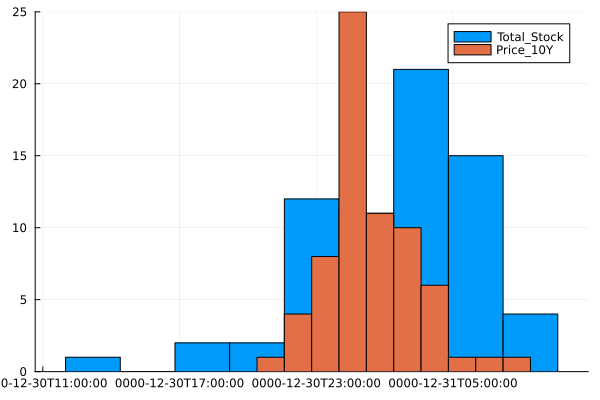

In [26]:
histogram(returns1y)

In [8]:
returns1y = moving(sum,s_data[:Total_Stock_CPI, :Price_10Y_CPI, :T_Bill_CPI],4) ./1
returns3y = moving(sum,s_data[:Total_Stock_CPI, :Price_10Y_CPI, :T_Bill_CPI],12) ./3
returns5y = moving(sum,s_data[:Total_Stock_CPI, :Price_10Y_CPI, :T_Bill_CPI],20) ./5
returns10y = moving(sum,s_data[:Total_Stock_CPI, :Price_10Y_CPI, :T_Bill_CPI],40) ./10
cum_returns = merge(TimeSeries.rename!(returns1y, [:RealStock1y, :RealBonds1y, :RealTBill1y]), 
                    TimeSeries.rename!(returns3y, [:RealStock3y, :RealBonds3y, :RealTBill3y]), 
                    TimeSeries.rename!(returns5y, [:RealStock5y, :RealBonds5y, :RealTBill5y]),
                    TimeSeries.rename!(returns10y, [:RealStock10y, :RealBonds10y, :RealTBill10y]))
returns_summarystats(expm1.(cum_returns),1)

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
RealStock1y,0.1608,0.5606,0.0729,0.1826,-0.4113,-0.364,-0.0138,0.7816,0.3453,0.4531,0.0883
RealBonds1y,0.0985,0.419,0.0305,0.0907,-0.2218,0.9104,-0.0301,0.7728,1.7513,0.3098,0.0193
RealTBill1y,0.0218,0.0631,0.0078,0.021,-0.0377,0.2582,-0.0099,0.9413,-0.3332,0.3593,0.0077
RealStock3y,0.0932,0.2948,0.0644,0.1217,-0.1598,-0.1412,0.0039,0.9335,0.0149,0.6902,0.0758
RealBonds3y,0.0557,0.1861,0.0277,0.0596,-0.1299,0.1664,-0.0034,0.9214,0.7679,0.4972,0.024
RealTBill3y,0.0191,0.0548,0.0081,0.0204,-0.0241,0.3685,-0.009,0.9871,-0.4404,0.4226,0.0084
RealStock5y,0.0748,0.2456,0.0632,0.116,-0.0885,0.1167,-0.0034,0.9541,-0.6401,0.845,0.0752
RealBonds5y,0.045,0.1915,0.0274,0.0539,-0.0916,0.5641,-0.0027,0.958,1.3174,0.6086,0.0236
RealTBill5y,0.0172,0.0525,0.0084,0.0186,-0.0201,0.3271,-0.0066,0.9916,-0.4944,0.488,0.0102
RealStock10y,0.0538,0.158,0.0628,0.1057,-0.0516,-0.3223,0.0245,0.9753,-0.9033,1.1685,0.0675


In [9]:
round.(percentile(values(returns10y)[:,1], [5, 25, 50, 75, 95]), digits=4)

5-element Vector{Float64}:
 -0.0292
  0.0243
  0.0653
  0.1005
  0.1334

In [10]:
returns5y = moving(sum,returns[:Total_Stock, :Price_10Y, :T_Bill],15) ./ 5
percentile(values(returns5y)[:,1], [5, 25, 50, 75, 95]) .- 0.03

5-element Vector{Float64}:
 -0.05631638546077937
  0.0197682257575379
  0.055492855172298836
  0.07854526853104804
  0.13150548844326004

In [11]:
percentile(values(returns5y)[:,2], [5, 25, 50, 75, 95]) .- 0.03

5-element Vector{Float64}:
 -0.03182677373411721
 -0.013964106739768951
  0.00831352848251015
  0.02658206783196622
  0.07235629688679483

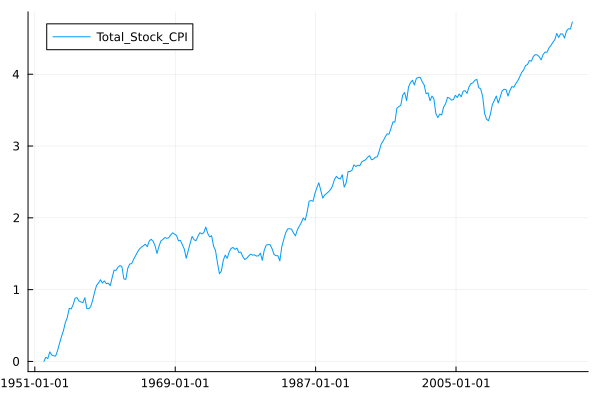

In [12]:
plot(cumsum(s_data[:Total_Stock_CPI]))

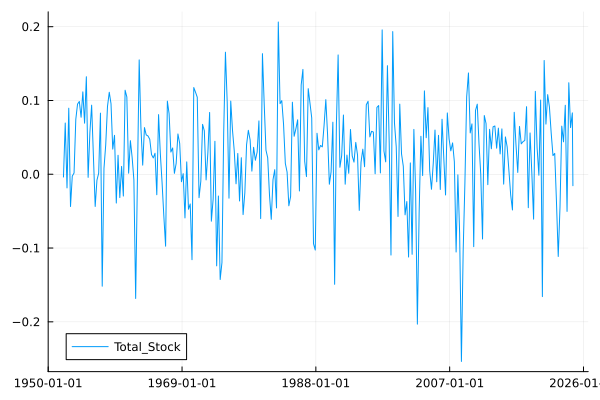

In [13]:
plot(returns[:Total_Stock])

In [14]:
cape = collapse(data_source[:CAPE], Dates.quarter, last)
Δcape = percentchange(cape, :log)
adj_returns = returns[:Total_Stock] .- Δcape
returns_summarystats(merge(returns[:Total_Stock], adj_returns, Δcape),4)


,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
Total_Stock,0.1368,0.8255,0.1042,0.2741,-1.0147,-0.6199,-0.0406,0.1422,1.2115,0.7619,0.1269
Total_Stock_CAPE,0.0235,0.2429,0.0901,0.1166,-0.1095,0.0858,0.0628,0.6842,1.2777,3.8333,0.0854
CAPE,0.1412,0.7461,0.0142,0.2052,-0.9743,-0.4754,-0.1406,0.165,0.6997,0.1002,0.0361


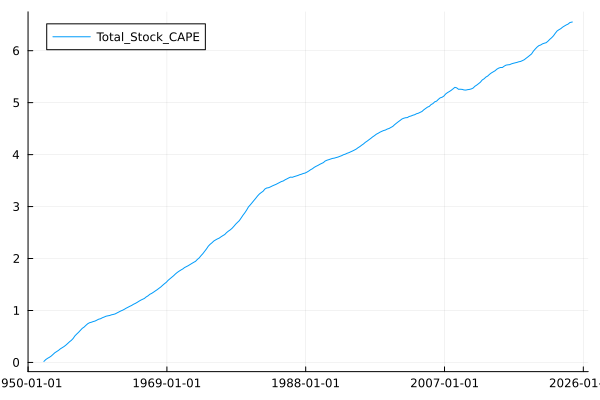

In [15]:
plot(cumsum(adj_returns))


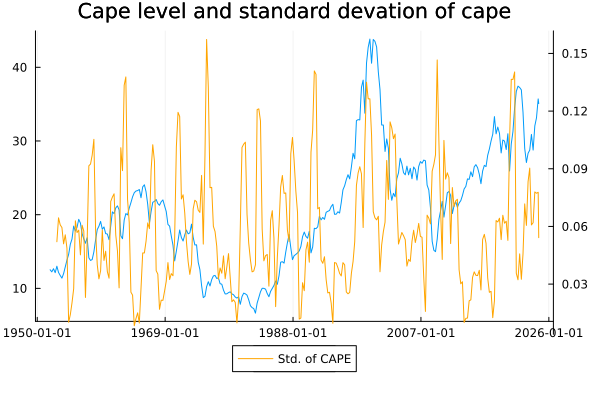

In [16]:
stdcape = moving(std,Δcape, 4)
plot(cape, label="CAPE")
plot!(twinx(),stdcape, color=:orange, label="Std. of CAPE")
plot!(legend=:outerbottom)
title!("Cape level and standard devation of cape")

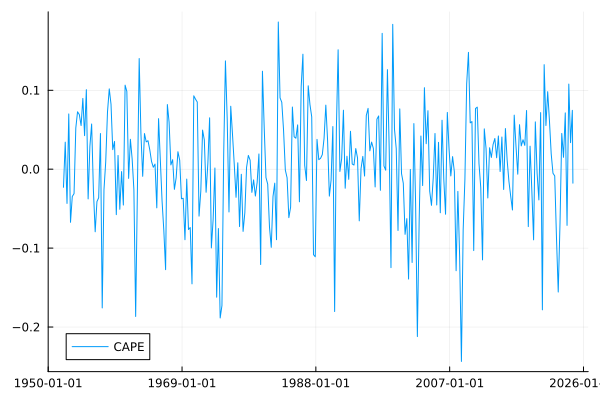

In [17]:
plot(Δcape)

In [18]:
r = returns[:Total_Stock]
sqrt(mean((values(r) .-  mean(values(r))) .^ 2))

0.06828153958153331

In [19]:
sqrt(mean((values(r) .-  mean(values(adj_returns))) .^ 2))

0.06837317748891925

In [20]:
std(values(returns[:Total_Stock]))

0.06839916505990531

In [21]:
std(values(returns[:Total_Stock]), mean=mean(values(adj_returns)))

0.06849096082771383

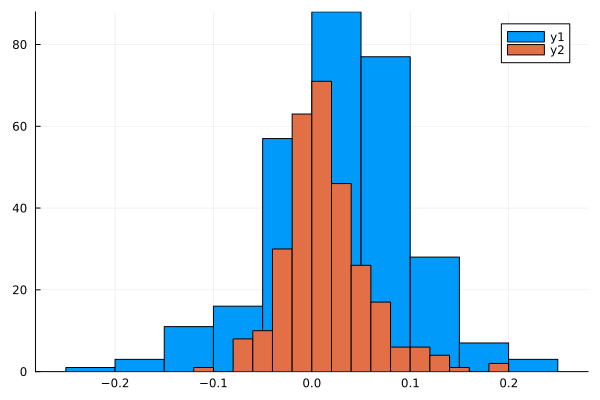

In [22]:
histogram(expm1.(values(returns[:Total_Stock]) ))
histogram!(expm1.(values(returns[:Price_10Y]) ))

In [23]:
returns_summarystats(data_source[:Yeld_10Y],1)

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
Yeld_10Y,0.0292,0.1584,0.0548,0.0736,0.0066,0.9377,0.0333,0.9774,0.6945,1.8772,0.0468


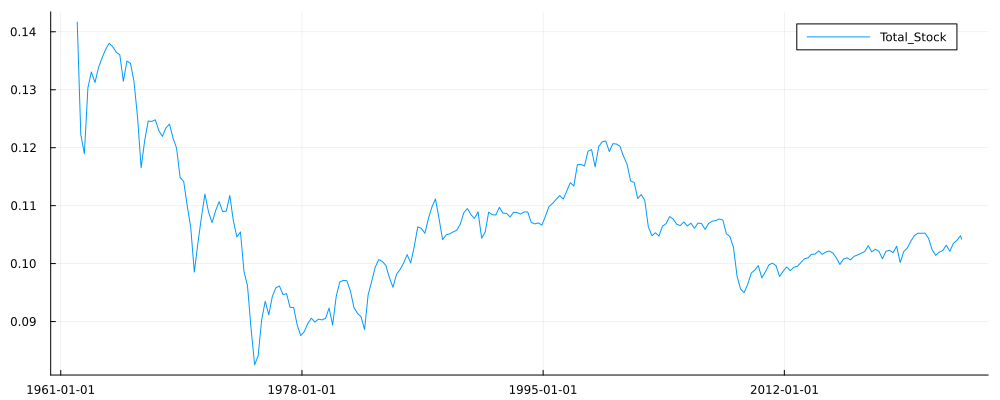

In [24]:
expand_mean = upto(mean, returns[:Total_Stock]) .* 4

plot(expand_mean[Date(1962,01,01):Date(2024,07,31)], size=(1000,400))